In [9]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [10]:
df = pd.read_csv('./../../error_dfs/error_2018_2019_ARIMA.csv', converters={'ags2': str, 'ags5': str} )

In [11]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [12]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2018-01-31,9.3,9.028416,0.271584,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2018-02-28,9.2,9.031855,0.168145,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2018-03-31,9.1,8.909250,0.190750,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2018-04-30,8.8,8.975852,0.175852,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2018-05-31,8.3,8.727940,0.427940,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
9619,16077,2019-08-31,7.0,7.006511,0.006511,16,Thüringen,Altenburger Land
9620,16077,2019-09-30,6.5,6.842809,0.342809,16,Thüringen,Altenburger Land
9621,16077,2019-10-31,6.5,6.451817,0.048183,16,Thüringen,Altenburger Land
9622,16077,2019-11-30,6.3,6.456085,0.156085,16,Thüringen,Altenburger Land


In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
df['error'] = df.apply(lambda x: mean_absolute_percentage_error(x['ground_truth'], x['pred']), axis=1)

In [15]:
#df.to_csv('./MAPE_errors_2018_2019_SARIMA.csv', index = False)

## Plot each variable

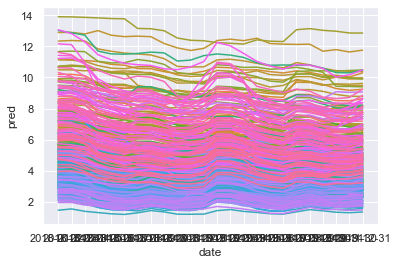

In [16]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.legend_.remove()

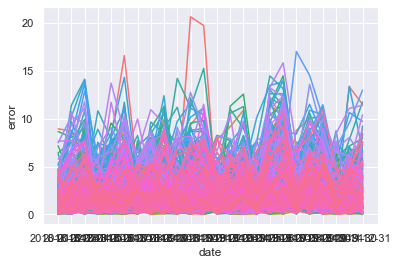

In [17]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.legend_.remove()

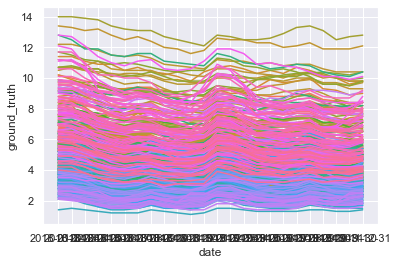

In [18]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.legend_.remove()

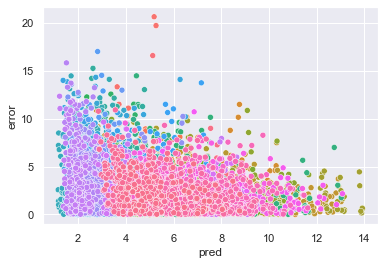

In [19]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [20]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [21]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [22]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

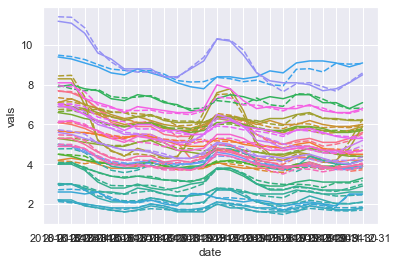

In [23]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.legend_.remove()

## Look into mean errors

In [24]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,8.120935,3.488621
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,7.955254,1.918640
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.533600,1.702006
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.105459,1.578530
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,5.946776,2.335766
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.363375,2.166469
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.330630,2.970069
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.744802,2.937768


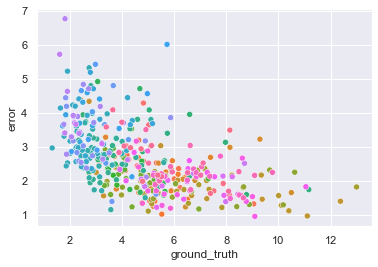

In [25]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

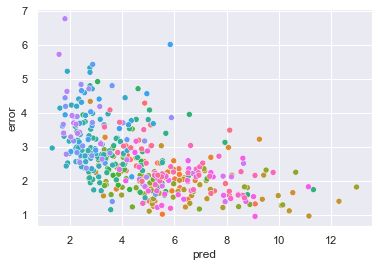

In [26]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [27]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09773,09,Freistaat Bayern,Dillingen a.d.Donau,1.816667,1.809585,6.764805
09464,09,Freistaat Bayern,Hof,5.729167,5.841161,6.008977
09779,09,Freistaat Bayern,Donau-Ries,1.612500,1.583671,5.719174
09476,09,Freistaat Bayern,Kronach,2.983333,2.871239,5.423567
08437,08,Baden-Württemberg,Sigmaringen,2.741667,2.763651,5.322390
...,...,...,...,...,...,...
05113,05,Nordrhein-Westfalen,Essen,10.400000,10.400197,1.116241
05366,05,Nordrhein-Westfalen,Euskirchen,5.008333,5.035260,1.106819
03159,03,Niedersachsen,Göttingen,5.529167,5.540002,1.018786


<AxesSubplot:xlabel='error', ylabel='Density'>

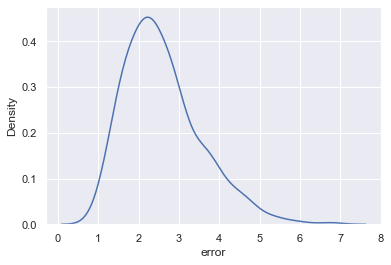

In [28]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [29]:
df.sort_values(by = ['error'], ascending=False)

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
274,01059,2018-11-30,4.3,5.188028,20.651809,01,Schleswig-Holstein,Schleswig-Flensburg
275,01059,2018-12-31,4.4,5.268043,19.728239,01,Schleswig-Holstein,Schleswig-Flensburg
6642,09476,2019-07-31,3.4,2.821355,17.018968,09,Freistaat Bayern,Kronach
149,01054,2018-06-30,4.4,5.130167,16.594695,01,Schleswig-Holstein,Nordfriesland
7457,09773,2019-06-30,1.8,1.514995,15.833597,09,Freistaat Bayern,Dillingen a.d.Donau
...,...,...,...,...,...,...,...,...
2023,05366,2018-08-31,5.2,5.200034,0.000648,05,Nordrhein-Westfalen,Euskirchen
1471,04011,2018-08-31,9.3,9.300055,0.000589,04,Bremen,Bremen
1154,03405,2018-03-31,11.1,11.099951,0.000437,03,Niedersachsen,Wilhelmshaven
207,01056,2019-04-30,4.5,4.500014,0.000309,01,Schleswig-Holstein,Pinneberg


In [30]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

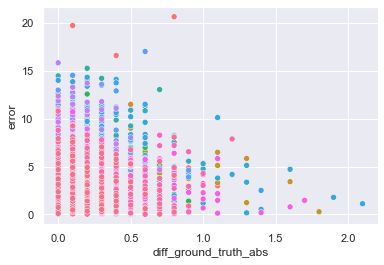

In [31]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

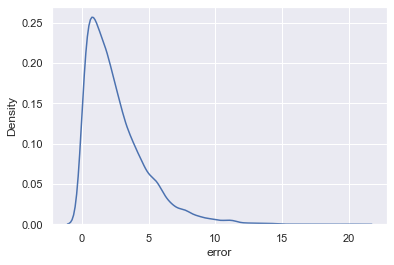

In [32]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

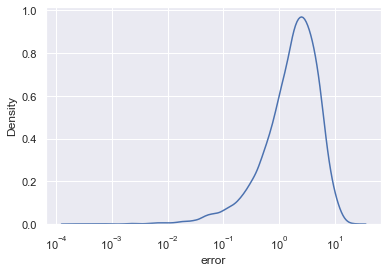

In [33]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [35]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_/_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,2,99,99,1,1,C,1
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,1,99,99,1,0,C/D,1
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,1,5,99,1,0,C/D,1
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,2,5,99,1,0,D,1
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,2,5,99,1,0,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,2,99,99,2,0,C*,1
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,2,99,99,2,0,C*,1
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,2,99,99,2,2,C*,1
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,1,99,99,2,0,C*,1


### Merge to df with mean errors

In [36]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [37]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

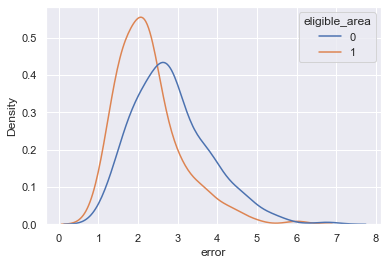

Ttest_indResult(statistic=-6.359894762620668, pvalue=5.648436418062891e-10)

In [38]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

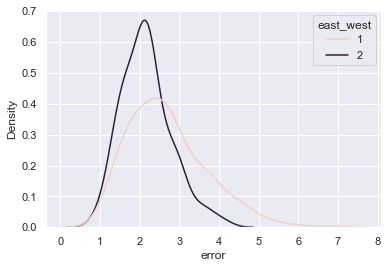

Ttest_indResult(statistic=5.8296082223328884, pvalue=2.5043836704314255e-08)

In [39]:
compare_error_in_two_groups(df_mixed, 'east_west')

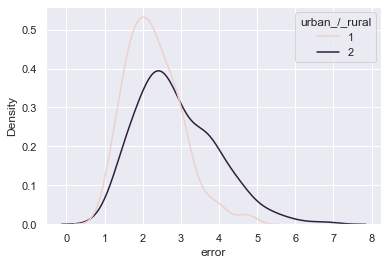

Ttest_indResult(statistic=-6.599261106703804, pvalue=1.4619955722343505e-10)

In [40]:
compare_error_in_two_groups(df_mixed, 'urban_/_rural')

### Compare compare error in multiple groups

In [41]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

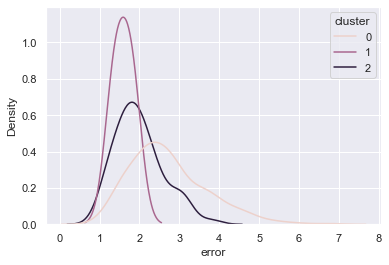

              sum_sq     df         F        PR(>F)
cluster    30.947301    1.0  37.11011  2.629896e-09
Residual  332.738790  399.0       NaN           NaN


In [42]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


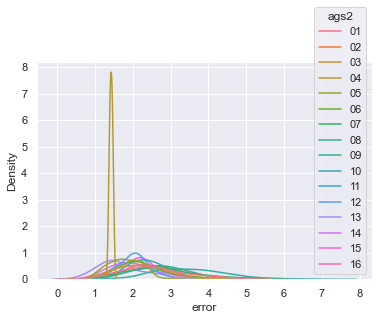

              sum_sq     df          F        PR(>F)
ags2      151.972422   15.0  18.424061  9.019411e-37
Residual  211.713670  385.0        NaN           NaN


In [43]:
compare_error_in_two_groups(df_mixed, "ags2")

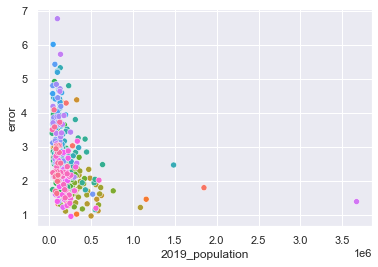

In [44]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

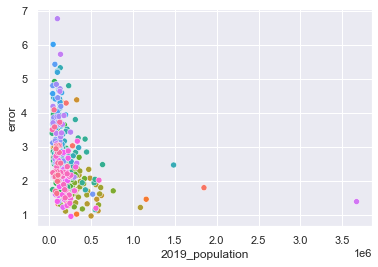

In [45]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [46]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [47]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_/_rural'] = df_mixed['urban_/_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [48]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [49]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.5502 -0.1097 -0.0066 0.1013 0.6427


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -147.539635  2.174060e+05+1.100000e-05j  -0.0007+0.0000j  0.999459
supermarkets_population                             0.004122  4.881000e-03+0.000000e+00j   0.8446-0.0000j  0.398830
supermarkets_average_distance                       0.000105  7.640000e-04-0.000000e+00j   0.1369+0.0000j  0.891180
public_transport_availability                       0.008916  1.850000e-03-0.000000e+00j   4.8200+0.0002j  0.000002
average_distance_bus_stop                          -0.000146  2.350000e-04+2.000000e-06j  -0.6191+0.0053j  0.536164
average_distance_train_station                      0.000038  1.700000e-05+9.000000e-06j   1.8021-0.9417j  0.042679
average_distance_public_transport                   0.000309  3.660000e-04-2.400000e-

### Sequential Feature Selector

In [50]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [51]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(177,)","[-0.08617040365761097, -0.04095623993769948, -...",-0.177277,"(ags2_09,)",0.318352,0.247688,0.123844
2,"(30, 177)","[0.07969125762931073, -0.0710296260159371, -0....",-0.043375,"(share_of_motorised_vehicle_driver, ags2_09)",0.324163,0.25221,0.126105
3,"(30, 173, 177)","[0.19468958025456007, 0.11280959657631462, -0....",0.021279,"(share_of_motorised_vehicle_driver, ags2_05, a...",0.251369,0.195573,0.097787
4,"(30, 75, 173, 177)","[0.16355400578506873, 0.10880953734699583, -0....",0.091088,"(share_of_motorised_vehicle_driver, Commute_wi...",0.150413,0.117026,0.058513
5,"(30, 75, 147, 173, 177)","[0.17655165831322894, 0.10577888190738383, -0....",0.119342,"(share_of_motorised_vehicle_driver, Commute_wi...",0.152519,0.118665,0.059332
6,"(30, 69, 75, 147, 173, 177)","[0.17458742557442375, 0.16667756991730254, -0....",0.149685,"(share_of_motorised_vehicle_driver, Number_of_...",0.175742,0.136733,0.068367
7,"(26, 30, 69, 75, 147, 173, 177)","[0.20617311976470432, 0.20132100804000364, -0....",0.181686,"(_percentage_out_of_home, share_of_motorised_v...",0.131764,0.102517,0.051259
8,"(26, 30, 69, 74, 75, 147, 173, 177)","[0.22578954631014803, 0.22827734405065347, 0.0...",0.202381,"(_percentage_out_of_home, share_of_motorised_v...",0.12438,0.096772,0.048386
9,"(26, 30, 69, 74, 75, 147, 150, 173, 177)","[0.2511910849770762, 0.22536532529199726, 0.05...",0.212789,"(_percentage_out_of_home, share_of_motorised_v...",0.116198,0.090406,0.045203
10,"(26, 29, 30, 69, 74, 75, 147, 150, 173, 177)","[0.2523262823584813, 0.2502515139331225, 0.072...",0.225798,"(_percentage_out_of_home, proportion_of_motori...",0.113493,0.088301,0.044151


In [52]:
list(summary_table_select['feature_names'])[:5]

[('ags2_09',),
 ('share_of_motorised_vehicle_driver', 'ags2_09'),
 ('share_of_motorised_vehicle_driver', 'ags2_05', 'ags2_09'),
 ('share_of_motorised_vehicle_driver',
  'Commute_within_150km',
  'ags2_05',
  'ags2_09'),
 ('share_of_motorised_vehicle_driver',
  'Commute_within_150km',
  'standing_water_percentage',
  'ags2_05',
  'ags2_09')]

### Ridge

In [53]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [54]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.5917 -0.1098 -0.0072 0.1071 0.6581


Coefficients:
                                                   Estimate                  Std. Error         t value   p value
_intercept                                       -12.184084  2.208986e+05+1.100000e-05j -0.0001+0.0000j  0.999956
supermarkets_population                            0.004046  2.759000e-03+3.100000e-04j  1.4485-0.1625j  0.145749
supermarkets_average_distance                      0.000098  7.800000e-04+2.610000e-04j  0.1131-0.0379j  0.905114
public_transport_availability                      0.007015  1.204000e-03+1.414000e-03j  2.4495-2.8754j  0.000183
average_distance_bus_stop                         -0.000171  2.340000e-04+9.100000e-05j -0.6363+0.2475j  0.495173
average_distance_train_station                     0.000040 -5.000000e-06+2.000000e-05j -0.4902-1.8567j  0.055523
average_distance_public_transport                  0.000280  1.190000e-04-1.960000e-04j  0.6333+1.0

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

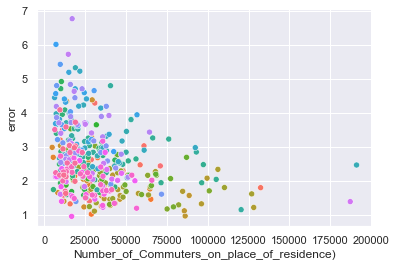

In [55]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.legend_.remove()

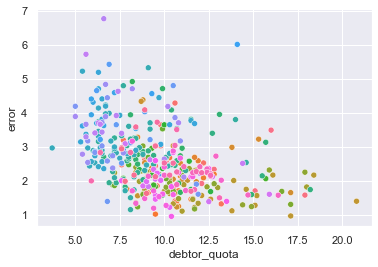

In [56]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

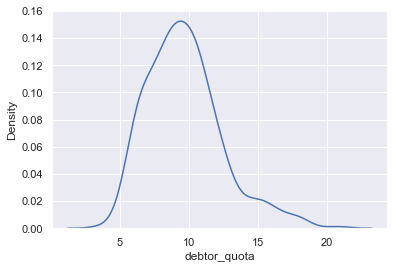

In [57]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

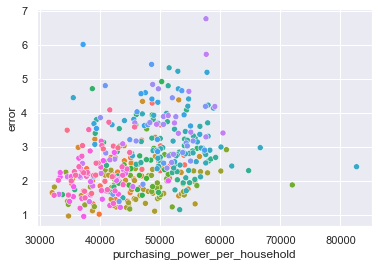

In [58]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

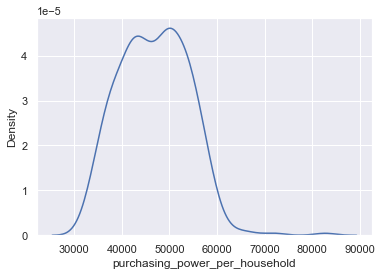

In [59]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

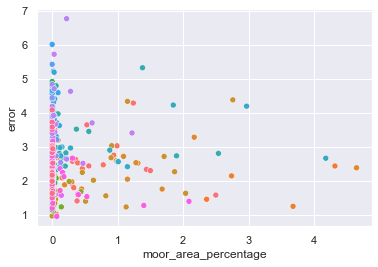

In [60]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()